# Big Data for Health (CSE6250) 

Goal: Using Lightgbm model to predict sepsis onset using MIMIC III Data

Author: Zhensheng Wang
         
Created: 11/13/2021

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score
from tableone import TableOne
import lightgbm as lgbm
from hyperopt import fmin, hp, tpe, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from tableone import TableOne
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import os, gc
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= os.path.join(os.getcwd(), "bdfh.json")
# from google.cloud import bigquery
# bqclient = bigquery.Client()

## Load Data

In [9]:
case_labs = pd.read_csv('./data_v2/case_48h_labs_ex3h.csv')
case_vitals = pd.read_csv('./data_v2/case_48h_vitals_ex3h.csv')
case_static = pd.read_csv('./data_v2/static_variables_cases_ex3h.csv')

control_labs = pd.read_csv('./data_v2/control_48h_labs_ex3h.csv')
control_vitals = pd.read_csv('./data_v2/control_48h_vitals_ex3h.csv')
control_static = pd.read_csv('./data_v2/static_variables_controls_ex3h.csv')

## Helper function


In [3]:
def race_recode(df):
    cond_white = df['ethnicity'].str.contains('WHITE')
    cond_black = df['ethnicity'].str.contains('BLACK')
    cond_asian = df['ethnicity'].str.contains('ASIAN')
    cond_hispa = df['ethnicity'].str.contains('HISPANIC')

    df.loc[cond_white, 'ethnicity'] = 'WHITE'
    df.loc[cond_black, 'ethnicity'] = 'BLACK'
    df.loc[cond_asian, 'ethnicity'] = 'ASIAN'
    df.loc[cond_hispa, 'ethnicity'] = 'HISPANIC'
    df.loc[~(cond_white | cond_black | cond_asian | cond_hispa), 'ethnicity'] = 'OTHER'
    
    df['ethnicity'] = df['ethnicity'].apply(lambda x: x[0] + x[1:].lower())
    return df

## Table1

In [34]:

t1_case = case_static.sort_values(['subject_id', 'admission_age']).drop_duplicates('subject_id')[['gender', 'ethnicity', 'admission_age', 'subject_id']]
t1_case = t1_case[t1_case.subject_id.isin(case_vitals.subject_id) & t1_case.subject_id.isin(case_labs.subject_id)]
t1_case.loc[:, 'gender'] = t1_case['gender'].apply(lambda x: 'Female' if x == 'F' else 'Male')
t1_case = race_recode(t1_case)
t1_case['Sepsis'] = 'Yes'

t1_control = control_static.sort_values(['subject_id', 'admission_age']).drop_duplicates('subject_id')[['gender', 'ethnicity', 'admission_age', 'subject_id']]
t1_control = t1_control[t1_control.subject_id.isin(control_vitals.subject_id) & t1_control.subject_id.isin(control_labs.subject_id)]

t1_control.loc[:, 'gender'] = t1_control['gender'].apply(lambda x: 'Female' if x == 'F' else 'Male')
t1_control = race_recode(t1_control)
t1_control['Sepsis'] = 'No'

t1 = pd.concat((t1_case, t1_control), ignore_index=True).drop_duplicates('subject_id')

order = {
    'ETHNICITY': ['White', 'Black', 'Hispanic', 'Asian', 'Other']
}

label = {
    'admission_age': 'Age (yrs) at first admission',
    # 'los': 'Length of stay (days)',
    'ethnicity': 'Race/Ethnicity',
    # 'MARITAL_STATUS': 'Marital status',
    'gender': 'Gender',
    # 'INSURANCE': 'Insurance'
}

t1_pivot = TableOne(
    t1, 
    columns=['gender', 'ethnicity', 'admission_age'], 
    categorical=['gender', 'ethnicity'],
    nonnormal = ['admission_age'],  
    groupby = 'Sepsis', 
    limit = 6, 
    order = order,
    pval = True,
    missing = False,
    rename = label)

In [35]:
t1_pivot.to_csv('t1_pivot.csv')
t1_pivot

Grouped by Sepsis                                            
                                                                Overall                No               Yes P-Value
n                                                                  4953              4357               596        
Gender, n (%)                                Female         2187 (44.2)       1902 (43.7)        285 (47.8)   0.061
                                             Male           2766 (55.8)       2455 (56.3)        311 (52.2)        
Race/Ethnicity, n (%)                        Asian            131 (2.6)         111 (2.5)          20 (3.4)   0.163
                                             Black            470 (9.5)         403 (9.2)         67 (11.2)        
                                             Hispanic         181 (3.7)         153 (3.5)          28 (4.7)        
                                             Other           506 (10.2)        449 (10.3)          57 (9.6)        
                                             White          3665 (74.0)       3241 (74.4)        424 (71.1)        
Age (yrs) at first admission, median [Q1,Q3]           66.1 [53.7,77.6]  66.2 [53.8,77.6]  65.3 [52.6,77.6]   0.460

## Clean data

In [10]:
case_labs = case_labs.drop(columns=['chart_time', 'icustay_id', 'sepsis_onset', 'hr_feature'])
apply_dict = {col: ['mean', 'median', 'std'] for col in case_labs.columns if col != 'subject_id'}
case_labs = case_labs.groupby('subject_id').agg(apply_dict)
# case_labs = case_labs.fillna(case_labs.median())
case_labs.columns = ['_'.join(col) for col in case_labs.columns]

case_static = case_static[['gender', 'ethnicity', 'admission_age', 'subject_id']]
case_static['label'] = 1
case_static = race_recode(case_static)
case_static['ethnicity'] = LabelEncoder().fit_transform(case_static['ethnicity'])
case_static['gender'] = LabelEncoder().fit_transform(case_static['gender'])

case_vitals = case_vitals.drop(columns=['chart_time', 'icustay_id', 'sepsis_onset', 'hr_feature'])
apply_dict = {col: ['mean', 'median', 'std'] for col in case_vitals.columns if col != 'subject_id'}
case_vitals = case_vitals.groupby('subject_id').agg(apply_dict)
# case_vitals = case_vitals.fillna(case_vitals.median())
case_vitals.columns = ['_'.join(col) for col in case_vitals.columns]

case_all = case_static.merge(case_labs, on='subject_id').merge(case_vitals, on='subject_id')


control_labs = control_labs.drop(columns=['chart_time', 'icustay_id', 'control_onset_time', 'hr_feature'])
apply_dict = {col: ['mean', 'median', 'std'] for col in control_labs.columns if col != 'subject_id'}
control_labs = control_labs.groupby('subject_id').agg(apply_dict)
# control_labs = control_labs.fillna(control_labs.median())
control_labs.columns = ['_'.join(col) for col in control_labs.columns]

control_static = control_static[['gender', 'ethnicity', 'admission_age', 'subject_id']]
control_static['label'] = 0
control_static = race_recode(control_static)
control_static['ethnicity'] = LabelEncoder().fit_transform(control_static['ethnicity'])
control_static['gender'] = LabelEncoder().fit_transform(control_static['gender'])

control_vitals = control_vitals.drop(columns=['chart_time', 'icustay_id', 'control_onset_time', 'hr_feature'])
apply_dict = {col: ['mean', 'median', 'std'] for col in control_vitals.columns if col != 'subject_id'}
control_vitals = control_vitals.groupby('subject_id').agg(apply_dict)
# control_vitals = control_vitals.fillna(control_vitals.median())
control_vitals.columns = ['_'.join(col) for col in control_vitals.columns]

control_all = control_static.merge(control_labs, on='subject_id').merge(control_vitals, on='subject_id')



In [11]:
case_control_all = pd.concat((case_all, control_all), ignore_index=True).sample(frac=1).reset_index(drop=True)

X, y = case_control_all.drop(columns=['subject_id', 'label']), case_control_all.label
X = MinMaxScaler().fit_transform(X)

## Model training and prediction

In [12]:
print(f"Number of features included: {X.shape[1]}")
print(f"Number of observations: {X.shape[0]}")
print(y.value_counts())

Number of features included: 135
Number of observations: 5657
0    5041
1     616
Name: label, dtype: int64


## Lightgbm CV

In [21]:
# def lgb_f1_score(y_hat, data):
#     y_true = data.get_label()
#     y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
#     return 'f1', f1_score(y_true, y_hat), True

In [33]:
lgbm_param = {
        'num_leaves': scope.int(hp.quniform('num_leaves', 2, 21, 1)), # hp.choice('num_leaves', np.arange(2, 21)),
        'learning_rate': hp.uniform('learning_rate', 0.005, 0.1),
        'feature_fraction': hp.uniform('feature_fraction', 0.01, 0.8),
        'max_depth': scope.int(hp.quniform('max_depth', 2, 11, 1)), #hp.choice('max_depth', np.arange(2, 11)),
        'objective': 'binary',
        # 'boosting_type': 'dart',
        'metric': 'auc',
        'verbose': -1,
        # 'device_type': 'gpu'
    }

def f_lgbm(params):
    tr_data = lgbm.Dataset(X, y)
    res = lgbm.cv(params, tr_data, num_boost_round=1000, early_stopping_rounds=100, seed=42, return_cvbooster=True)
    return {
        'loss': -np.mean(res['auc-mean']).round(5), 
        'status': STATUS_OK,
        'boosters': res['cvbooster'].boosters, 
        'auc-mean': res['auc-mean'],
        'auc-std': res['auc-stdv']
    }

In [34]:
trials = Trials()
lgbm_best = fmin(f_lgbm, lgbm_param, algo=tpe.suggest, rstate=np.random.RandomState(42), max_evals=50, trials=trials)

100%|██████████| 50/50 [01:40<00:00,  2.01s/trial, best loss: -0.76494]


In [18]:
lgbm_best

{'feature_fraction': 0.2053922909202318,
 'learning_rate': 0.013791375580212269,
 'max_depth': 10.0,
 'num_leaves': 21.0}

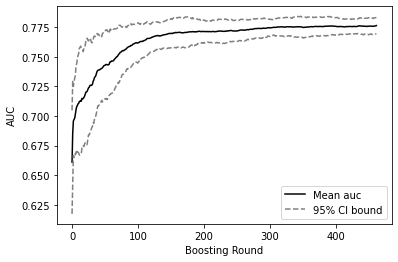

In [57]:
train_auc_df = pd.DataFrame(dict(auc =trials.best_trial['result']['auc-mean'], std=trials.best_trial['result']['auc-std']))
train_auc_df['auc_l'] = train_auc_df['auc'] - 1.96 * train_auc_df['std']
train_auc_df['auc_h'] = train_auc_df['auc'] + 1.96 * train_auc_df['std']

plt.plot(train_auc_df['auc'], 'k-', label='Mean auc')
plt.plot(train_auc_df['auc_l'], '--', color='gray', label='95% CI bound')
plt.plot(train_auc_df['auc_h'], '--', color='gray')
plt.xlabel('Boosting Round')
plt.ylabel('AUC')
plt.legend()
# plt.title('AUC Curve on 5-fold cross validation lightgbm model')
plt.savefig('lightgbm-auc.jpg')

In [18]:
# dir(res['cvbooster'])
feature_imp = np.zeros((X.shape[1]))
for booster in trials.best_trial['result']['boosters']:
    feature_imp += booster.feature_importance() / 5
    

In [19]:
feature_imp = pd.DataFrame(dict(cols = case_control_all.drop(columns=['subject_id', 'label']).columns, feature_importance = feature_imp)). \
    sort_values('feature_importance', ascending=False, ignore_index=True).head(10)
feature_imp.to_latex('feature_imp.tex', index=False)
feature_imp

,cols,feature_importance
0,TempC_std,145.2
1,DiaBP_std,129.2
2,HeartRate_std,124.8
3,RespRate_std,116.6
4,SysBP_std,114.2
5,WBC_std,114.0
6,PLATELET_mean,109.2
7,PLATELET_std,106.2
8,RespRate_mean,105.8
9,TempC_mean,103.4
